# Predicting Evergreeness of Content with Decision Trees and Random Forests

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
import numpy as np
import json

data = pd.read_csv("stumbleupon.tsv", sep='\t')
data['title'] = data.boilerplate.apply(lambda x: json.loads(x).get('title', ''))
data['body'] = data.boilerplate.apply(lambda x: json.loads(x).get('body', ''))
data.head()

/Applications/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


url  urlid  \
0  http://www.bloomberg.com/news/2010-12-23/ibm-p...   4042   
1  http://www.popsci.com/technology/article/2012-...   8471   
2  http://www.menshealth.com/health/flu-fighting-...   1164   
3  http://www.dumblittleman.com/2007/12/10-foolpr...   6684   
4  http://bleacherreport.com/articles/1205138-the...   9006   

                                         boilerplate alchemy_category  \
0  {"title":"IBM Sees Holographic Calls Air Breat...         business   
1  {"title":"The Fully Electronic Futuristic Star...       recreation   
2  {"title":"Fruits that Fight the Flu fruits tha...           health   
3  {"title":"10 Foolproof Tips for Better Sleep "...           health   
4  {"title":"The 50 Coolest Jerseys You Didn t Kn...           sports   

  alchemy_category_score  avglinksize  commonlinkratio_1  commonlinkratio_2  \
0               0.789131     2.055556           0.676471           0.205882   
1               0.574147     3.677966           0.508021           0.288770   
2               0.996526     2.382883           0.562016           0.321705   
3               0.801248     1.543103           0.400000           0.100000   
4               0.719157     2.676471           0.500000           0.222222   

   commonlinkratio_3  commonlinkratio_4  \
0           0.047059           0.023529   
1           0.213904           0.144385   
2           0.120155           0.042636   
3           0.016667           0.000000   
4           0.123457           0.043210   

                         ...                          linkwordscore  \
0                        ...                                     24   
1                        ...                                     40   
2                        ...                                     55   
3                        ...                                     24   
4                        ...                                     14   

   news_front_page  non_markup_alphanum_characters  numberOfLinks  \
0                0                            5424            170   
1                0                            4973            187   
2                0                            2240            258   
3                0                            2737            120   
4                0                           12032            162   

   numwords_in_url  parametrizedLinkRatio  spelling_errors_ratio label  \
0                8               0.152941               0.079130     0   
1                9               0.181818               0.125448     1   
2               11               0.166667               0.057613     1   
3                5               0.041667               0.100858     1   
4               10               0.098765               0.082569     0   

                                               title  \
0  IBM Sees Holographic Calls Air Breathing Batte...   
1  The Fully Electronic Futuristic Starting Gun T...   
2  Fruits that Fight the Flu fruits that fight th...   
3                10 Foolproof Tips for Better Sleep    
4  The 50 Coolest Jerseys You Didn t Know Existed...   

                                                body  
0  A sign stands outside the International Busine...  
1  And that can be carried on a plane without the...  
2  Apples The most popular source of antioxidants...  
3  There was a period in my life when I had a lot...  
4  Jersey sales is a curious business Whether you...  

[5 rows x 29 columns]

## Predicting "Greenness" Of Content

This dataset comes from [stumbleupon](https://www.stumbleupon.com/), a web page recommender. A description of the columns is below:

FieldName|Type|Description
---------|----|-----------
url|string|Url of the webpage to be classified
title|string|Title of the article
body|string|Body text of article
urlid|integer| StumbleUpon's unique identifier for each url
boilerplate|json|Boilerplate text
alchemy_category|string|Alchemy category (per the publicly available Alchemy API found at <a>www.alchemyapi.com</a>)
alchemy_category_score|double|Alchemy category score (per the publicly available Alchemy API found at <a>www.alchemyapi.com</a>)
avglinksize| double|Average number of words in each link
commonlinkratio_1|double|# of links sharing at least 1 word with 1 other links / # of links
commonlinkratio_2|double|# of links sharing at least 1 word with 2 other links / # of links
commonlinkratio_3|double|# of links sharing at least 1 word with 3 other links / # of links
commonlinkratio_4|double|# of links sharing at least 1 word with 4 other links / # of links
compression_ratio|double|Compression achieved on this page via gzip (measure of redundancy)
embed_ratio|double|Count of number of <embed> usage
frameBased|integer (0 or 1)|A page is frame-based (1) if it has no body markup but have a frameset markup
frameTagRatio|double|Ratio of iframe markups over total number of markups
hasDomainLink|integer (0 or 1)|True (1) if it contains an `<a>` with an url with domain
html_ratio|double|Ratio of tags vs text in the page
image_ratio|double|Ratio of <img> tags vs text in the page
is_news|integer (0 or 1) | True (1) if StumbleUpon's news classifier determines that this webpage is news
lengthyLinkDomain| integer (0 or 1)|True (1) if at least 3 `<a>` 's text contains more than 30 alphanumeric characters
linkwordscore|double|Percentage of words on the page that are in hyperlink's text
news_front_page| integer (0 or 1)|True (1) if StumbleUpon's news classifier determines that this webpage is front-page news
non_markup_alphanum_characters|integer| Page's text's number of alphanumeric characters
numberOfLinks|integer Number of <a>|markups
numwords_in_url| double|Number of words in url
parametrizedLinkRatio|double|A link is parametrized if it's url contains parameters or has an attached onClick event
spelling_errors_ratio|double|Ratio of words not found in wiki (considered to be a spelling mistake)
label|integer (0 or 1)|User-determined label. Either evergreen (1) or non-evergreen (0); available for train.tsv only

### What are 'evergreen' sites?

> #### Evergreen sites are those that are always relevant.  As opposed to breaking news or current events, evergreen websites are relevant no matter the time or season. 

> #### A sample of URLs is below, where label = 1 are 'evergreen' websites

More context here: https://www.kaggle.com/c/stumbleupon

In [3]:
data.alchemy_category.unique()

array(['business', 'recreation', 'health', 'sports', '?',
       'arts_entertainment', 'science_technology', 'gaming',
       'culture_politics', 'computer_internet', 'law_crime', 'religion',
       'weather', 'unknown'], dtype=object)

In [2]:
data[['alchemy_category','label']].head(10)

alchemy_category  label
0            business      0
1          recreation      1
2              health      1
3              health      1
4              sports      0
5                   ?      0
6  arts_entertainment      1
7                   ?      0
8                   ?      1
9                   ?      1

In [3]:
data.groupby(['alchemy_category'])['label'].sum()

alchemy_category
?                     1176
arts_entertainment     350
business               626
computer_internet       73
culture_politics       157
gaming                  28
health                 290
law_crime               13
recreation             841
religion                30
science_technology     132
sports                  78
unknown                  2
weather                  0
Name: label, dtype: int64

In [4]:
data.groupby(['alchemy_category']).label.mean()

alchemy_category
?                     0.502135
arts_entertainment    0.371945
business              0.711364
computer_internet     0.246622
culture_politics      0.457726
gaming                0.368421
health                0.573123
law_crime             0.419355
recreation            0.684296
religion              0.416667
science_technology    0.456747
sports                0.205263
unknown               0.333333
weather               0.000000
Name: label, dtype: float64

In [5]:
data.groupby(['alchemy_category','is_news']).label.agg(['mean','count'])

mean  count
alchemy_category   is_news                 
?                  1        0.514199    986
                   ?        0.493363   1356
arts_entertainment 1        0.387870    709
                   ?        0.323276    232
business           1        0.719269    602
                   ?        0.694245    278
computer_internet  1        0.218182    220
                   ?        0.328947     76
culture_politics   1        0.466942    242
                   ?        0.435644    101
gaming             1        0.387755     49
                   ?        0.333333     27
health             1        0.575581    344
                   ?        0.567901    162
law_crime          1        0.428571     21
                   ?        0.400000     10
recreation         1        0.695018    823
                   ?        0.662562    406
religion           1        0.500000     46
                   ?        0.269231     26
science_technology 1        0.446512    215
                   ?        0.486486     74
sports             1        0.200692    289
                   ?        0.219780     91
unknown            1        0.500000      4
                   ?        0.000000      2
weather            1        0.000000      2
                   ?        0.000000      2

In [6]:
data.groupby(['alchemy_category']).filter(lambda c:len(c)>100).groupby('alchemy_category').label.mean()

alchemy_category
?                     0.502135
arts_entertainment    0.371945
business              0.711364
computer_internet     0.246622
culture_politics      0.457726
health                0.573123
recreation            0.684296
science_technology    0.456747
sports                0.205263
Name: label, dtype: float64

In [7]:
data[data.alchemy_category.isin(['health', 'science_technology', 'computer_internet'])].label.mean()

0.4537121906507791

In [8]:
data[~data.alchemy_category.isin(['health', 'science_technology', 'computer_internet'])].label.mean()
# not in list

0.5236357868020305

In [13]:
data[data.alchemy_category.isin(['weather'])].label.count()

4

### Exercises to Get Started

> ### Does being a news site affect evergreeness? 
Compute or plot the percentage of news related evergreen sites.

In [19]:
print data[data.is_news == '1'].label.mean()
print data[data.is_news == '?'].label.mean()

0.516915641476
0.507562434049


> ### Does category in general affect evergreeness? 
Plot the rate of evergreen sites for all Alchemy categories.

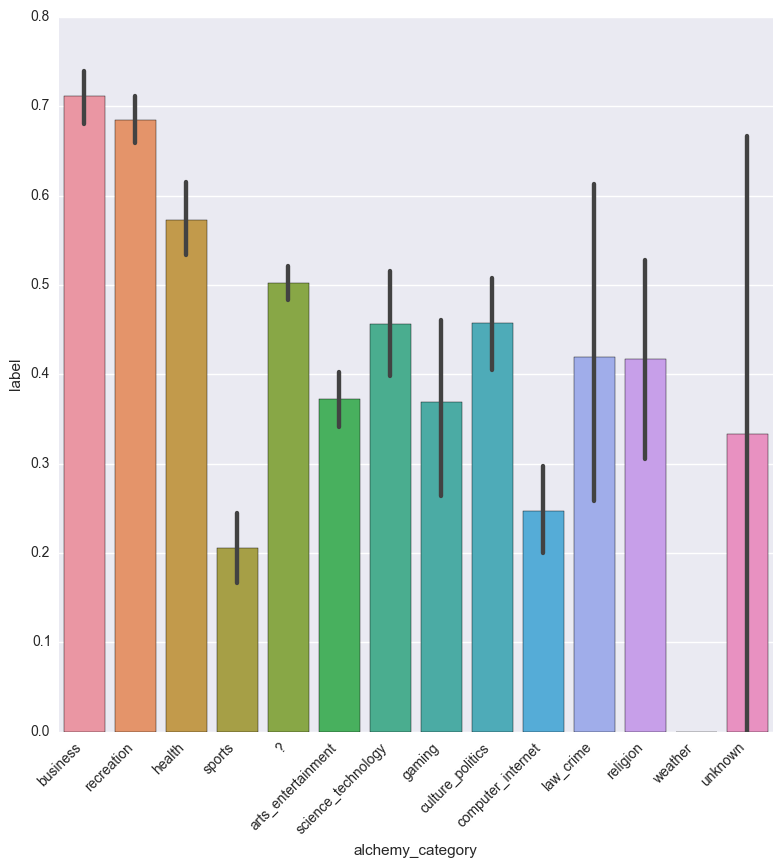

In [9]:
p = sns.factorplot(x='alchemy_category', 
              y='label',
              kind='bar',
              data = data,
              size = 8
            )
p.set_xticklabels(rotation=45, horizontalalignment='right')

> ### How many articles are there per category?

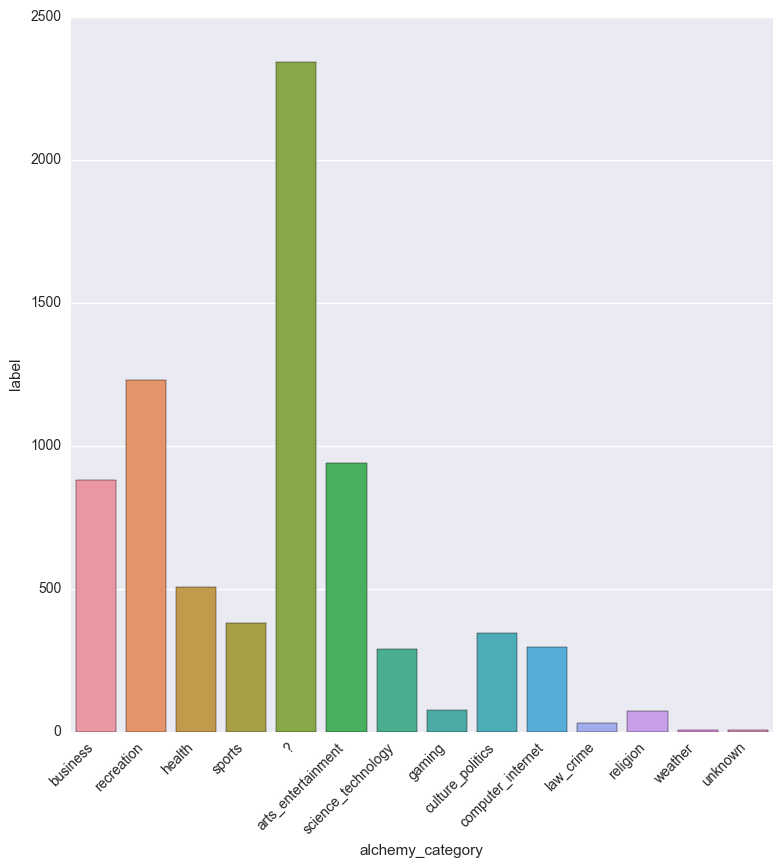

In [10]:
p = sns.factorplot(x='alchemy_category', 
              y='label',
              kind='bar',
              data = data,
              size = 8,
              estimator=len
            )
p.set_xticklabels(rotation=45, horizontalalignment='right')

> #### Let's try extracting some of the text content.
> ### Create a feature for the title containing 'recipe'. 
Is the % of evegreen websites higher or lower on pages that have recipe in the the title?

In [11]:
data['recipe'] = data['title'].str.contains('recipe')

In [12]:
data.groupby('recipe')[['label']].mean()

label
recipe          
False   0.494452
True    0.892351

###  Let's Explore Some Decision Trees

 ### Demo: Build a decision tree model to predict the "evergreeness" of a given website. 

In [13]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_features=None,max_depth=4,min_samples_leaf=6)

X = data[['image_ratio', 'html_ratio', 'recipe', 'label']].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)
    
    
# Fits the model
model.fit(X, y)

# Helper function to visualize Decision Trees (creates a file tree.png)
# need to install graphviz to use .dot files
# use brew install graphviz
from sklearn.tree import export_graphviz
from os import system 
def build_tree_image(model):
    dotfile = open("tree.dot", 'w')
    export_graphviz(model,
                              out_file = dotfile,
                              feature_names = X.columns)
    dotfile.close()
    system("dot -Tpng tree.dot -o tree.png")
    
build_tree_image(model)

print model.n_features_
print model.n_classes_
print model.tree_.node_count

3
2
29


In [14]:
model.score(X,y)

0.57158336719490721

In [15]:
from sklearn.metrics import roc_auc_score

In [16]:
model.predict_proba(X)[ :,1]

array([ 0.51262506,  0.60361135,  0.51262506, ...,  0.24908425,
        0.43382353,  0.39679715])

## Decision Trees in scikit-learn

 ### Exercise: Evaluate the decision tree using cross-validation; use AUC as the evaluation metric.

In [17]:
from sklearn.cross_validation import cross_val_score, ShuffleSplit

# ... #

scores = cross_val_score(DecisionTreeClassifier(), X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

# take a look at this
# http://stats.stackexchange.com/questions/68893/area-under-curve-of-roc-vs-overall-accuracy
# why do we think that average AUC and average accuracy have similar or different performance?
scores = cross_val_score(DecisionTreeClassifier(), X, y, scoring='accuracy', cv=5)
print('CV Accuracy {}, Average Accuracy {}'.format(scores, scores.mean()))

CV AUC [ 0.53434814  0.53752188  0.54493022  0.53382674  0.55922344], Average AUC 0.541970081881
CV Accuracy [ 0.53044655  0.53283683  0.54878049  0.5298103   0.55691057], Average Accuracy 0.539756947164


In [18]:
# how do we reduce overfitting?
scores = cross_val_score(DecisionTreeClassifier(max_depth=4, min_samples_leaf=6), X, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

scores = cross_val_score(DecisionTreeClassifier(max_depth=4, min_samples_leaf=6), X, y, scoring='accuracy', cv=5)
print('CV Accuracy {}, Average Accuracy {}'.format(scores, scores.mean()))

CV AUC [ 0.58897404  0.59417121  0.62089155  0.58831057  0.59460279], Average AUC 0.597390032253
CV Accuracy [ 0.55548038  0.56872038  0.57655827  0.55555556  0.55894309], Average Accuracy 0.563051533721


###  Adjusting Decision Trees to Avoid Overfitting

 ### Demo: Control for overfitting in the decision model by adjusting the maximum number of questions (max_depth) or the minimum number of records in each final node (min_samples_leaf)

In [20]:
model = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5)

model.fit(X, y)
build_tree_image(model)

In [21]:
model.score(X, y)

0.55641338209399971

 ### Demo: Build a random forest model to predict the evergreeness of a website. 

In [22]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20)
    
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Demo: Extracting importance of features  
feature importance evaluation: http://scikit-learn.org/stable/modules/ensemble.html#feature-importance-evaluation  
feature importance is calculated using the expected fraction of the samples each feature contributes to predicting. If it's higher in the tree, it's affecting more samples

In [23]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort('Importance Score', inplace=True, ascending=False)

features_df.head()

Features  Importance Score
1   html_ratio          0.523025
0  image_ratio          0.449019
2       recipe          0.027957

##  Independent Practice: Evaluate Random Forest Using Cross-Validation

1. Continue adding input variables to the model that you think may be relevant
2. For each feature:
  - Evaluate the model for improved predictive performance using cross-validation
  - Evaluate the _importance_ of the feature
  - 
3. **Bonus**: Just like the 'recipe' feature, add in similar text features and evaluate their performance.


In [28]:
data.columns

Index([u'url', u'urlid', u'boilerplate', u'alchemy_category',
       u'alchemy_category_score', u'avglinksize', u'commonlinkratio_1',
       u'commonlinkratio_2', u'commonlinkratio_3', u'commonlinkratio_4',
       u'compression_ratio', u'embed_ratio', u'framebased', u'frameTagRatio',
       u'hasDomainLink', u'html_ratio', u'image_ratio', u'is_news',
       u'lengthyLinkDomain', u'linkwordscore', u'news_front_page',
       u'non_markup_alphanum_characters', u'numberOfLinks', u'numwords_in_url',
       u'parametrizedLinkRatio', u'spelling_errors_ratio', u'label', u'title',
       u'body', u'recipe'],
      dtype='object')

In [29]:
# create dummy variables for the alchemy categories
data = pd.concat([data, pd.get_dummies(data.alchemy_category)], axis=1)

In [30]:
# comparing to 0.62
dummy_categories = data.columns[-14: ]
predictor_columns = ['image_ratio', 
          'html_ratio', 
          'recipe', 
          'label', 
          'non_markup_alphanum_characters',
          'compression_ratio',
          'image_ratio',
          'html_ratio',
          'frameTagRatio']

predictor_list = np.hstack([predictor_columns, dummy_categories])

X = data[predictor_list].dropna()
y = X['label']
X.drop('label', axis=1, inplace=True)

for n_trees in range(1, 100, 20):
    model = RandomForestClassifier(n_estimators=n_trees, max_depth=4, min_samples_leaf=6)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5)
    print('n trees: {}, CV AUC {}, Average AUC {}'.format(n_trees, scores, scores.mean()))

n trees: 1, CV AUC [ 0.61599059  0.63281511  0.65133745  0.6657106   0.65911705], Average AUC 0.64499415999
n trees: 21, CV AUC [ 0.72502158  0.72168818  0.72461892  0.72508838  0.73787584], Average AUC 0.726858579421
n trees: 41, CV AUC [ 0.72706475  0.72335423  0.73058316  0.73043984  0.73596402], Average AUC 0.729481196988
n trees: 61, CV AUC [ 0.72922427  0.73000374  0.73080273  0.7303691   0.739637  ], Average AUC 0.732007369088
n trees: 81, CV AUC [ 0.72765113  0.72668174  0.73076874  0.72862907  0.73686251], Average AUC 0.730118635954


In [31]:
model.fit(X, y)
print model.feature_importances_
model.score(X, y)

[  4.04453880e-02   2.02146639e-02   1.09478774e-01   2.68467451e-01
   7.25766563e-02   3.14049517e-02   1.57077809e-02   1.66495848e-01
   2.29206674e-03   1.48399742e-02   7.52827372e-02   3.24779095e-02
   4.50739839e-04   8.56396234e-04   4.40428834e-03   7.98043973e-05
   8.56621157e-02   2.53368381e-04   3.85649977e-04   5.82168556e-02
   6.58106998e-06   0.00000000e+00]


0.6737098740349452